In [1]:
import ctypes
from pathlib import Path
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [2]:
class MapsForgeHeader(ctypes.BigEndianStructure):
    _pack_ = 1
    _fields_ = [
        ("magic_byte", ctypes.c_char * 20),
        ("header_size", ctypes.c_uint32),
        ("file_version", ctypes.c_uint32),
        ("file_size", ctypes.c_uint64),
        ("date_of_creation", ctypes.c_uint64),
        ("minLat", ctypes.c_int32),
        ("minLon", ctypes.c_int32),
        ("maxLat", ctypes.c_int32),  # most nothern point
        ("maxLon", ctypes.c_int32),
        ("tile_size", ctypes.c_uint16),
    ]


class ParsedFileName:
    country: str
    state: str
    creationDate: str
    minLong: int
    minLat: int
    sizeNorthSouth: int
    sizeWestEast: int

    def __init__(self, filename):
        self.country = filename[:2]
        self.state = filename[2:6]
        self.creationDate = filename[6:12]
        self.field1 = int(filename[12:15], 36)
        self.field2 = int(filename[15:18], 36)
        self.z1 = int(filename[18:21], 36)
        self.z2 = int(filename[21:24], 36)


def parseHeader(file: Path) -> MapsForgeHeader:
    header = MapsForgeHeader.from_buffer_copy(file.read_bytes())
    return header


def parseFilename(filename) -> ParsedFileName:
    return ParsedFileName(filename)

In [3]:
files = [f for f in Path("./allmaps").glob(("*.map")) if f.is_file()]
data = []


print("--- files ----   (", len(files), ")")

for i in files:
    print(i.name)

--- files ----   ( 626 )
asia_China_Anhui-CN010025040256C2ID039045.map
asia_China_Beijing-CN020025040255B2D902R04Q.map
asia_China_Chongqing-CN030025040250B2K903N02Y.map
asia_China_Fujian-CN040025040256Y2MZ03503H.map
asia_China_Gansu-CN05002504024RV2BA0AV08Q.map
asia_China_Guangdong-CN06002504025332OT04U041.map
asia_China_Guangxi-CN07002504024ZO2OF05203U.map
asia_China_Guizhou-CN08002504024Z82MD03V03F.map
asia_China_Hainan-CN090025040252F2SP02M02Z.map
asia_China_Hebei-CN100025040255B2BT049066.map
asia_China_Heilongjiang-CN11002504025702140C60AL.map
asia_China_Henan-CN12002504025352EJ04J06C.map
asia_China_Hongkong-CN130025040255Q2R400E00A.map
asia_China_Hubei-CN140025040251C2JD06F039.map
asia_China_Hunan-CN150025040252I2LS03I03Z.map
asia_China_Inner_Mongolia-CN16002504024V421C0J60EY.map
asia_China_Jiangsu-CN170025040257A2HF03L03X.map
asia_China_Jiangxi-CN180025040255E2LF03J04H.map
asia_China_Jilin-CN19002504025AM28F06J055.map
asia_China_Liaoning-CN200025040258Q2B604L042.map
asia_China_Ma

In [4]:
for f in files:
    header = parseHeader(f)
    # fix modified name (my maps are named like Vorarlberg-AT08002303103BS27H00H00P.map)
    humanName, filename = f.name.split("-")
    pf = parseFilename(filename)
    data.append({"file": f, "header": header, "parsedFilename": pf, "Name": humanName})

In [5]:
names = [d["Name"] for d in data]
minLat = [d["header"].minLat for d in data]
minLon = [d["header"].minLon for d in data]
maxLat = [d["header"].maxLat for d in data]
maxLon = [d["header"].maxLon for d in data]

f1 = [d["parsedFilename"].field1 for d in data]
f2 = [d["parsedFilename"].field2 for d in data]
f3 = [d["parsedFilename"].z1 for d in data]
f4 = [d["parsedFilename"].z2 for d in data]


df = pd.DataFrame(
    {
        "name": names,
        "minLat": minLat,
        "minLon": minLon,
        "maxLat": maxLat,
        "maxLon": maxLon,
        "f1": f1,
        "f2": f2,
        "f3": f3,
        "f4": f4,
    }
)
df["minLat"] = df["minLat"] / 1000000
df["minLon"] = df["minLon"] / 1000000
df["maxLat"] = df["maxLat"] / 1000000
df["maxLon"] = df["maxLon"] / 1000000

df["angleDiffLongitude"] = df["maxLon"] - df["minLon"]
df["angleDiffLatgitude"] = df["maxLat"] - df["minLat"]

display(df)

,name,minLat,minLon,maxLat,maxLon,f1,f2,f3,f4,angleDiffLongitude,angleDiffLatgitude
0,asia_China_Anhui,29.141565,114.795271,34.689614,119.934019,6708,3253,117,149,5.138748,5.548049
1,asia_China_Beijing,35.177401,113.169069,41.068783,117.526822,6671,3069,99,170,4.357753,5.891382
2,asia_China_Chongqing,28.150997,105.275303,32.186718,111.013218,6491,3321,131,106,5.737915,4.035721
3,asia_China_Fujian,23.531542,115.760366,28.473141,120.723117,6730,3419,113,125,4.962751,4.941599
4,asia_China_Gansu,32.514122,91.926489,43.386098,109.115823,6187,2998,391,314,17.189334,10.871976
...,...,...,...,...,...,...,...,...,...,...,...
621,south_america_Brazil_Sergipe,-11.590000,-38.265000,-9.495000,-36.260000,3225,4313,45,48,2.005000,2.095000
622,south_america_Brazil_State_of_Espirito_San,-21.510000,-41.920000,-17.850000,-28.590000,3142,4508,303,89,13.330000,3.660000
623,south_america_Brazil_State_of_Goias,-19.520000,-53.270000,-12.375000,-45.885000,2883,4379,168,170,7.385000,7.145000
624,south_america_Brazil_State_of_Rio_De_Janeiro,-23.700000,-44.910000,-20.745000,-40.655000,3074,4578,96,73,4.255000,2.955000


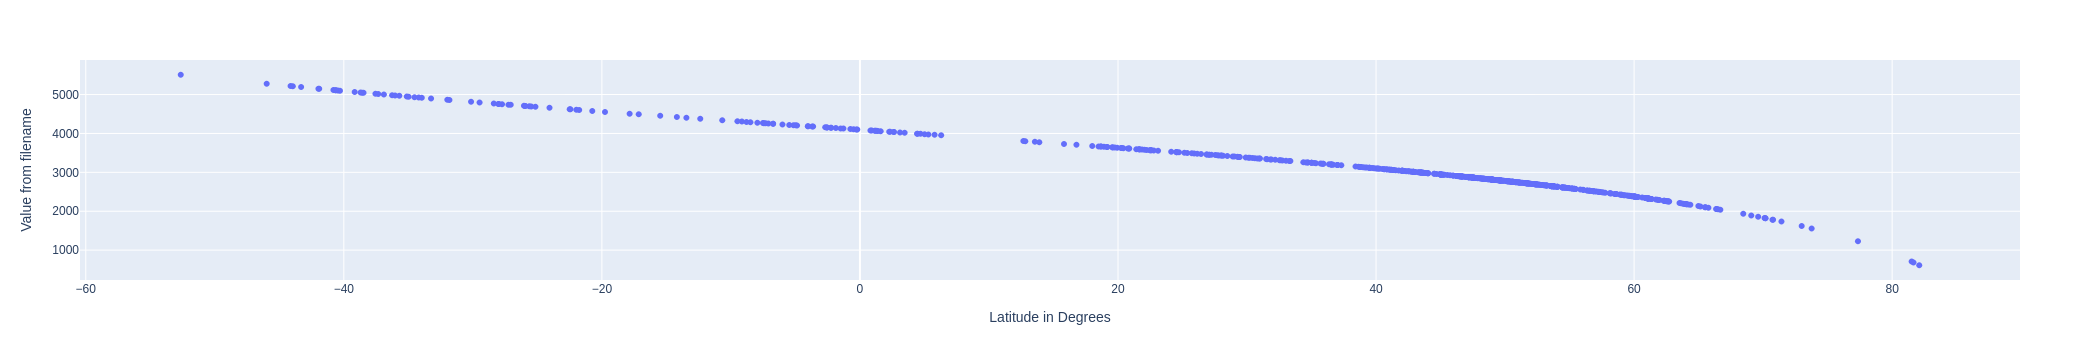

In [6]:
fig = px.scatter(
    df,
    x="maxLat",
    y="f2",
    hover_name="name",
    hover_data=["maxLat", "f2"],
    labels={
        "f2": "Value from filename",
        "maxLat": "Latitude in Degrees",
    },
)
fig.show()

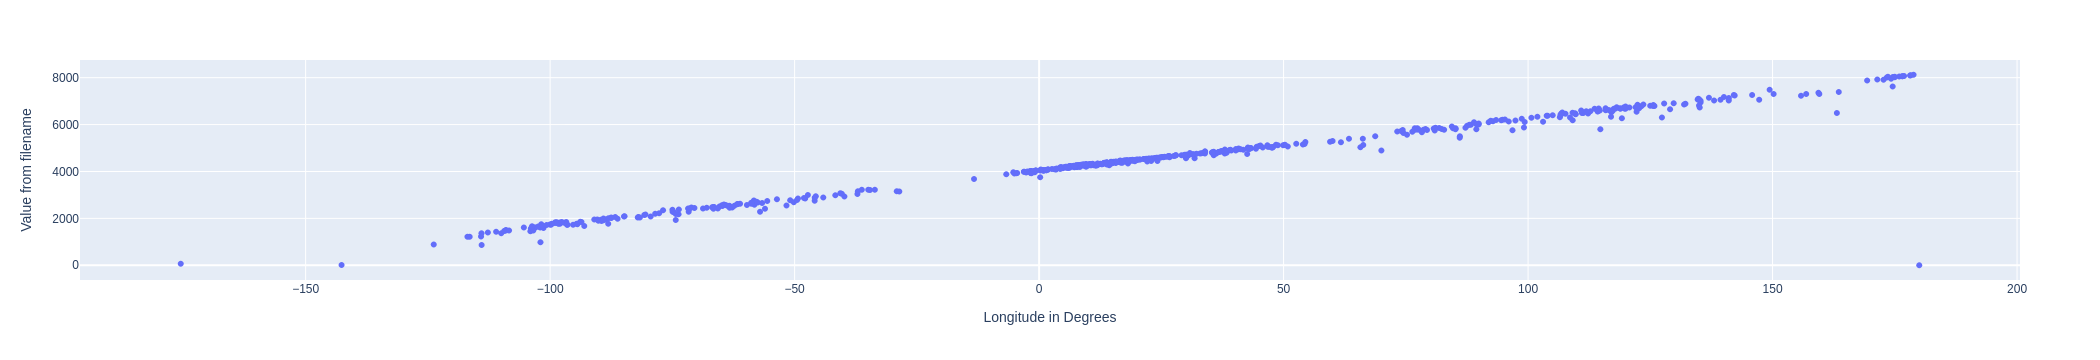

In [7]:
fig = px.scatter(
    df,
    x="maxLon",
    y="f1",
    hover_name="name",
    hover_data=["maxLon", "f1"],
    labels={
        "f1": "Value from filename",
        "maxLon": "Longitude in Degrees",
    },
)
fig.show()

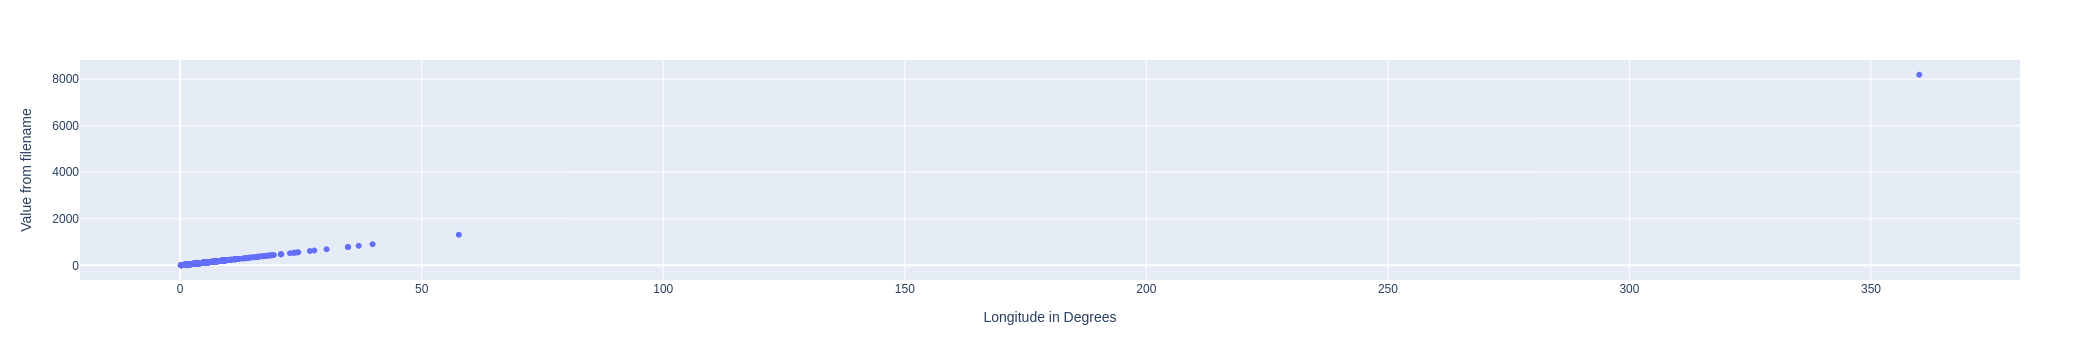

In [8]:
fig = px.scatter(
    df,
    x="angleDiffLongitude",
    y="f3",
    hover_name="name",
    hover_data=["angleDiffLongitude", "f3"],
    labels={
        "f3": "Value from filename",
        "angleDiffLongitude": "Longitude in Degrees",
    },
)
fig.show()

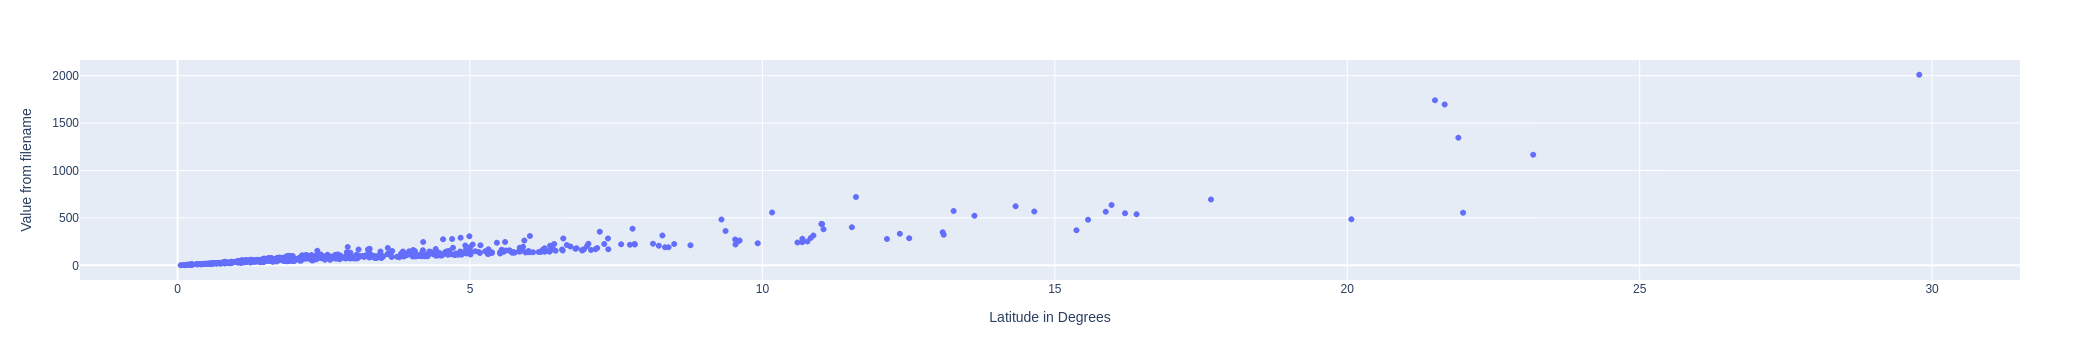

In [9]:
fig = px.scatter(
    df,
    x="angleDiffLatgitude",
    y="f4",
    hover_name="name",
    hover_data=["angleDiffLatgitude", "f4"],
    labels={
        "f4": "Value from filename",
        "angleDiffLatgitude": "Latitude in Degrees",
    },
)
fig.show()